In [1]:
import numpy as np
import timeit

import torch
import torch.nn as nn

import transformers
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast, BartForConditionalGeneration, PretrainedConfig
from transformers import BartTokenizerFast
from transformers.models.bart.configuration_bart import BartConfig

from model import BartSummaryModelV2
from utils import collate_fn, freeze, unfreeze_all, PrintInfo
from dataset import SummaryDataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

## load config, tokenizer, model

In [2]:
MODEL_NAME = "gogamza/kobart-summarization"

config = BartConfig.from_pretrained(MODEL_NAME)
tokenizer = BartTokenizerFast.from_pretrained(MODEL_NAME)
model = BartSummaryModelV2.from_pretrained(MODEL_NAME)

Some weights of BartSummaryModelV2 were not initialized from the model checkpoint at gogamza/kobart-summarization and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## load dataset, dataloader

In [3]:
train_path = "/opt/ml/dataset/Training/train.parquet"
train_dataset = SummaryDataset(train_path, tokenizer)

In [4]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, 
    BATCH_SIZE, 
    shuffle=True, 
    collate_fn=lambda x: collate_fn(x, pad_token_idx=tokenizer.pad_token_id)
)

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

In [6]:
model.cuda()
model.train()

BartSummaryModelV2(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): BartE

In [7]:
EPOCH = 16
ext_losses = []
gen_losses = []

backward_steps = 64

optimizer.zero_grad()

for epoch in range(EPOCH):
    i = 0
    for idx, batch in tqdm(enumerate(train_dataloader)):
        if i % 100 == 0: print(i)
        # labels: 생성요약, answers: 추출요약
        input_ids = batch["input_ids"].cuda()  # (B, L_src)
        attention_mask = batch["attention_mask"].cuda()  # (B, L_src)
        answers = batch["answers"].cuda() # 추출요약 (B, 3)
        labels = batch["labels"].cuda()   # 생성요약 (B, L_tgt)

        ext_out = model.classify(input_ids=input_ids, attention_mask=attention_mask, labels=answers)
        
        # losses.append(ext_out.loss)
        ext_out.loss.backward()

        gen_out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        # print(ext_out.loss, gen_out.loss)
        ext_losses.append(ext_out.loss.item())
        gen_losses.append(gen_out.loss.item())

        if (i+1) % backward_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        i += 1

model.save_pretrained("./saved")


0it [00:00, ?it/s]

/opt/ml/final-project-level3-nlp-05/utils.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[key].append(torch.tensor(sample[key]))


0
100


KeyboardInterrupt: 

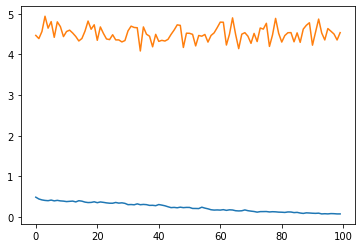

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
interval = 100
ext_mean = np.array(ext_losses)[:(len(ext_losses)//interval) * interval].reshape(interval, -1).mean(1)
gen_mean = np.array(gen_losses)[:(len(ext_losses)//interval) * interval].reshape(interval, -1).mean(1)

plt.plot(ext_mean)
plt.plot(gen_mean)

In [14]:
answers

tensor([[ 3,  4, 22],
        [ 5,  6, 10],
        [ 3,  5,  6],
        [26, 23, 33]], device='cuda:0')

In [15]:
ext_out.logits.argsort(descending=True)

tensor([[ 4,  3, 22, 18, 19, 21, 16, 30, 33, 28, 29, 31, 34, 32, 27, 26, 20, 23,
          9, 17, 11,  8, 12, 13, 25, 15,  5,  1, 14, 10,  0,  7,  6,  2, 24],
        [ 5,  6, 10, 27, 28, 32, 31, 30, 33, 34, 25, 26, 23, 24, 17, 22,  4, 21,
         19, 29,  3, 20, 13, 14, 18,  1,  8,  7, 16,  0,  9,  2, 15, 12, 11],
        [ 3,  5,  6,  9, 24, 19, 31, 33, 25, 23, 21, 20, 26, 28, 27, 32, 34, 29,
         30, 22, 18, 13, 17, 16, 14,  7,  2,  0, 15,  4,  1,  8, 12, 11, 10],
        [26, 23, 25, 27, 31, 33, 30, 28, 34, 24, 32, 29,  8, 13, 14, 15,  7, 11,
         20,  4, 19, 12,  5,  3, 16, 21,  2, 10,  6, 22,  0, 17, 18,  1,  9]],
       device='cuda:0')